# Exploratory Data Analysis
 *Disclaim: We're using the data from BraTS Challenge 2019* <br>
 [Full description of the data here](https://www.med.upenn.edu/cbica/brats2019/data.html)
 
## Overview
* Read into the NIfTI images and show an image overlaid with mask (per modality)<br>
**Folder Tree**:
<pre><code>root<br>   |---HGG<br>        |--- &lt;BraTS_2019_subject_ID><br>                        |---&lt;BraTS_2019_subject_ID>_flair.nii.gz<br>                        |---&lt;BraTS_2019_subject_ID>_seg.nii.gz<br>                        |---&lt;BraTS_2019_subject_ID>_t1.nii.gz<br>                        |---&lt;BraTS_2019_subject_ID>_t1ce.nii.gz<br>                        |---&lt;BraTS_2019_subject_ID>_t2.nii.gz<br>   |---LGG<br>        |--- &lt;BraTS_2019_subject_ID><br>                        |---&lt;BraTS_2019_subject_ID>_flair.nii.gz<br>                        |---&lt;BraTS_2019_subject_ID>_seg.nii.gz<br>                        |---&lt;BraTS_2019_subject_ID>_t1.nii.gz<br>                        |---&lt;BraTS_2019_subject_ID>_t1ce.nii.gz<br>                        |---&lt;BraTS_2019_subject_ID>_t2.nii.gz<br>   |---name_mapping.csv<br>   |---survival_data.csv  
</code></pre>

   where &lt;BraTS_2019_subject_ID> contains 260 subjects diagnosed with HGG, 77 subjects with LGG
    

* Do a statstical analysis on those converted images and compare different modalities
    * Draw a histogram of the intensities of the pixels of the images
    * Get a statistical description(median, std, ...)
* Bias-field Correction

## Setup

In [1]:
import ants
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt

## Read into the NIfTI images

In [ ]:
fp_list = [os.path.join(r,f[i]) for r,d,f in os.walk("/Users/young/Downloads/MICCAI_BraTS_2019_Data_Training") if d==[] 
                                for i in range(len(f))]

fp_list = sorted(fp_list)
fp_list

## Split the filepaths (training, mask)

In [4]:
# TODO: optimize the code 
fp_list_sep = []
fp_imgs_temp = []
fp_mask_temp = 0
for i in range(len(fp_list)):
    try:
        if fp_list[i].split("/")[-2] == fp_list[i+1].split("/")[-2]:
            if fp_list[i].split("_")[-1].split(".")[0] in ["flair","t1","t1ce","t2"]:
                fp_imgs_temp.append(fp_list[i])
            if fp_list[i].split("_")[-1].split(".")[0] == "seg":
                fp_mask_temp = fp_list[i]
        else : 
            fp_imgs_temp.append(fp_list[i])
            fp_list_sep.append((fp_imgs_temp, fp_mask_temp))
            fp_imgs_temp = []
    
    except IndexError as e: pass

In [5]:
fp_list_sep[0]

(['/Users/young/Downloads/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_flair.nii.gz',
  '/Users/young/Downloads/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_t1.nii.gz',
  '/Users/young/Downloads/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_t1ce.nii.gz',
  '/Users/young/Downloads/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_t2.nii.gz'],
 '/Users/young/Downloads/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_10_1/BraTS19_2013_10_1_seg.nii.gz')

## Create an image generator

In [6]:
fp_list_sep_gen = (([ants.image_read(fp) for fp in fp_list_sep[i][0]], ants.image_read(fp_list_sep[i][1])) for i in range(len(fp_list_sep)))
fp_list_sep_gen

<generator object <genexpr> at 0x153c83d00>

In [7]:
imgs, mask = next(fp_list_sep_gen)

*__Note__: normally different sequences may have different resolutions. <br> Here we see that the provided dataset has apparently been already rescaled to the same size.*

In [8]:
imgs

[ANTsImage (RAI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (240, 240, 155)
 	 Spacing    : (1.0, 1.0, 1.0)
 	 Origin     : (0.0, -239.0, 0.0)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.],
 ANTsImage (RAI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (240, 240, 155)
 	 Spacing    : (1.0, 1.0, 1.0)
 	 Origin     : (0.0, -239.0, 0.0)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.],
 ANTsImage (RAI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (240, 240, 155)
 	 Spacing    : (1.0, 1.0, 1.0)
 	 Origin     : (0.0, -239.0, 0.0)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.],
 ANTsImage (RAI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (240, 240, 155)
 	 Spacing    : (1.0, 1.0, 1.0)
 	 Origin     : (0.0, -239.0, 0.0)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]]

In [258]:
mask

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (240, 240, 155)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, -239.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

### Plot ANTsImage object(3D) as slices of an image

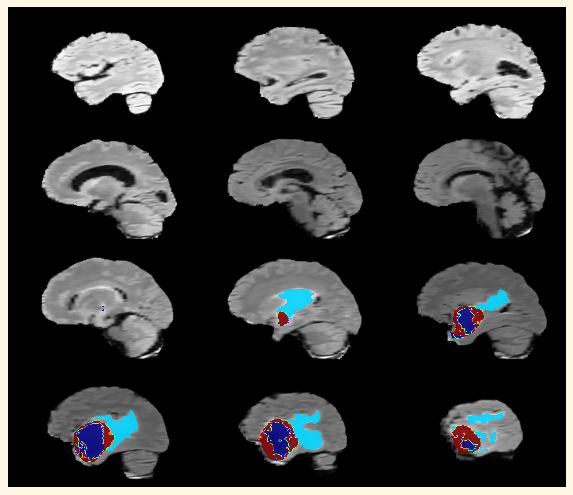

In [259]:
ants.plot(imgs[0], overlay=mask) # 0: flair, 1: t1, 2: t1_ce, 3:t2

## Do a statistical analysis on ANTsImage objects
### Median

In [260]:
[imgs[i].median() for i in range(len(imgs))], mask.median()

([0.0, 0.0, 0.0, 0.0], 0.0)

### Standard Deviation

In [261]:
[imgs[i].std() for i in range(len(imgs))], mask.std()

([146.77853, 146.6394, 195.37692, 185.86969], 0.28704822)

### Draw a historam of the pixel intensities
#### Flair without zero values

In [20]:
flair = imgs[0]
flair.flatten().shape

(8928000,)

In [22]:
flair_no_zero = (imgs[0].flatten()[imgs[0].flatten()!=0])
flair_no_zero.shape

(1487565,)

In [23]:
print("Non-zero pixel ratio of FLAIR image tensor: %.4f" % (flair_no_zero.shape[0] / flair.flatten().shape[0]))

Non-zero pixel ratio of FLAIR image tensor: 0.1666


#### T1 without zero values

In [24]:
t1 = imgs[1]
t1.flatten().shape

(8928000,)

In [25]:
t1_no_zero = (imgs[1].flatten()[imgs[1].flatten()!=0])
t1_no_zero.shape

(1488885,)

In [26]:
print("Non-zero pixel ratio of FLAIR image tensor: %.4f" % (t1_no_zero.shape[0] / t1.flatten().shape[0]))

Non-zero pixel ratio of FLAIR image tensor: 0.1668


#### T1_CE without zero values

In [30]:
t1ce = imgs[2]
t1ce.flatten().shape

(8928000,)

In [31]:
t1ce_no_zero = (imgs[2].flatten()[imgs[2].flatten()!=0])
t1ce_no_zero.shape

(1488730,)

In [32]:
print("Non-zero pixel ratio of FLAIR image tensor: %.4f" % (t1ce_no_zero.shape[0] / t1ce.flatten().shape[0]))

Non-zero pixel ratio of FLAIR image tensor: 0.1667


#### T2 without zero values

In [46]:
t2 = imgs[3]
t2.flatten().shape

(8928000,)

In [34]:
t2_no_zero = (imgs[3].flatten()[imgs[3].flatten()!=0])
t2_no_zero.shape

(1488860,)

In [36]:
print("Non-zero pixel ratio of FLAIR image tensor: %.4f" % (t2_no_zero.shape[0] / t2.flatten().shape[0]))

Non-zero pixel ratio of FLAIR image tensor: 0.1668


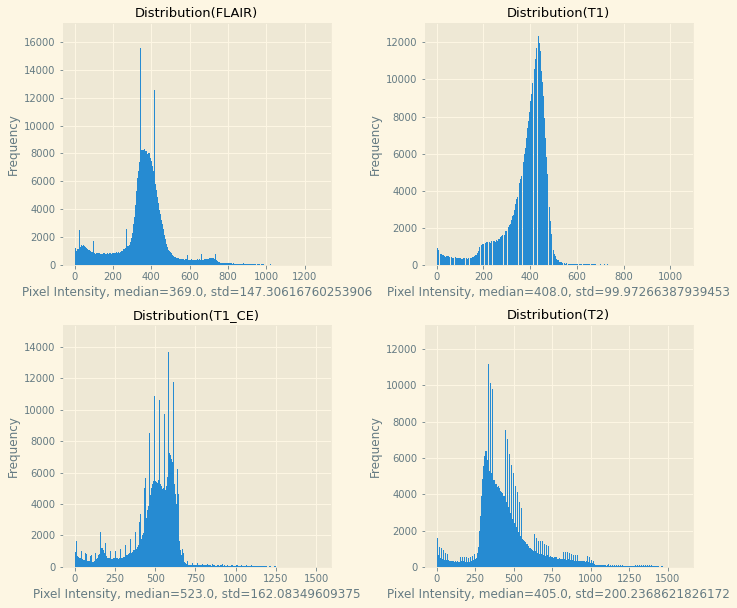

In [56]:
matplotlib.rcParams["figure.figsize"] = [10, 10]
matplotlib.rcParams["figure.subplot.right"] = 1.0
plt.style.use('Solarize_Light2')

plt.subplot(2,2,1)
plt.hist(flair_no_zero, bins='sqrt', range=(flair_no_zero.min(), flair_no_zero.max()))[2]
plt.title("Distribution(FLAIR)", fontsize=13)
plt.xlabel(f"Pixel Intensity, median={np.median(flair_no_zero)}, std={np.std(flair_no_zero)}")
plt.ylabel("Frequency")

plt.subplot(2,2,2)
plt.hist(t1_no_zero, bins='sqrt', range=(t1_no_zero.min(), t1_no_zero.max()))[2]
plt.title("Distribution(T1)", fontsize=13)
plt.xlabel(f"Pixel Intensity, median={np.median(t1_no_zero)}, std={np.std(t1_no_zero)}")
plt.ylabel("Frequency")

plt.subplot(2,2,3)
plt.hist(t1ce_no_zero, bins='sqrt', range=(t1ce_no_zero.min(), t1ce_no_zero.max()))[2]
plt.title("Distribution(T1_CE)", fontsize=13)
plt.xlabel(f"Pixel Intensity, median={np.median(t1ce_no_zero)}, std={np.std(t1ce_no_zero)}")
plt.ylabel("Frequency")

plt.subplot(2,2,4)
plt.hist(t2_no_zero, bins='sqrt', range=(t2_no_zero.min(), t2_no_zero.max()))[2]
plt.title("Distribution(T2)", fontsize=13)
plt.xlabel(f"Pixel Intensity, median={np.median(t2_no_zero)}, std={np.std(t2_no_zero)}")
plt.ylabel("Frequency")


plt.subplots_adjust(wspace=0.35, hspace=0.25)

#### N3 Bias-Corrected Flair

In [11]:
flair_n3bc = ants.n3_bias_field_correction(imgs[0])

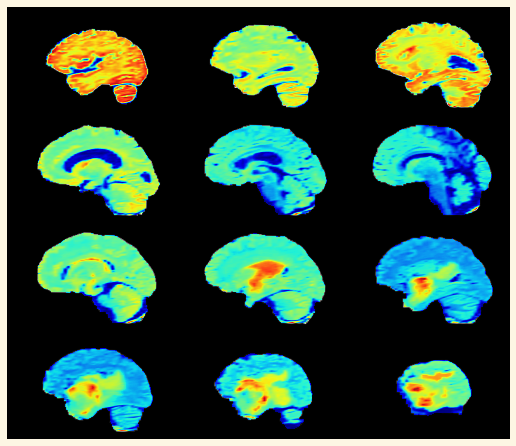

In [37]:
ants.plot(flair_n3bc, overlay=flair)

In [16]:
flair_n3bc_no_zero = flair_n3bc[flair_n3bc!=0]
flair_n3bc_no_zero.shape

(1487565,)

#### N3 Bias-Corrected T1

In [38]:
t1_n3bc = ants.n3_bias_field_correction(imgs[1])

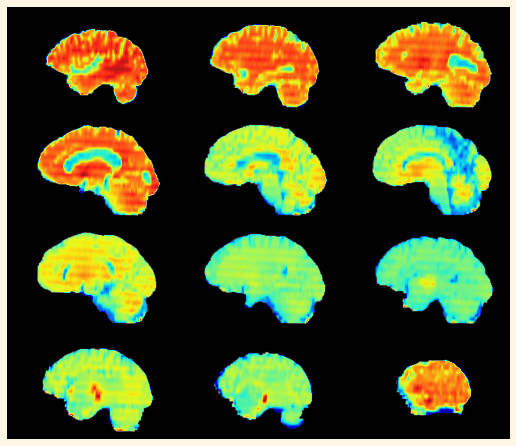

In [39]:
ants.plot(t1_n3bc, overlay=t1)

In [40]:
t1_n3bc_no_zero = t1_n3bc[t1_n3bc!=0]
t1_n3bc_no_zero.shape

(1488885,)

#### N3 Bias-Corrected T1_CE

In [41]:
t1ce_n3bc = ants.n3_bias_field_correction(imgs[2])

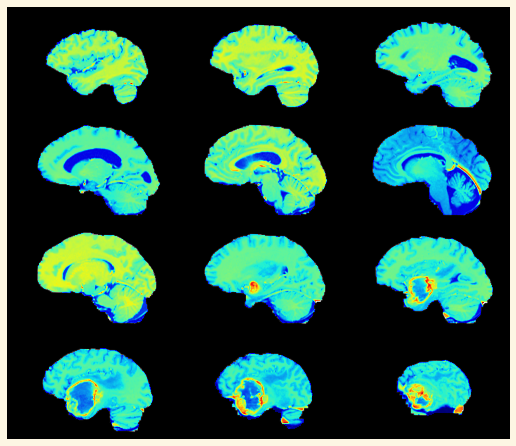

In [42]:
ants.plot(t1ce_n3bc, overlay=t1ce)

In [43]:
t1ce_n3bc_no_zero = t1ce_n3bc[t1ce_n3bc!=0]
t1ce_n3bc_no_zero.shape

(1488730,)

#### N3 Bias-Corrected T2

In [45]:
t2_n3bc = ants.n3_bias_field_correction(imgs[3])

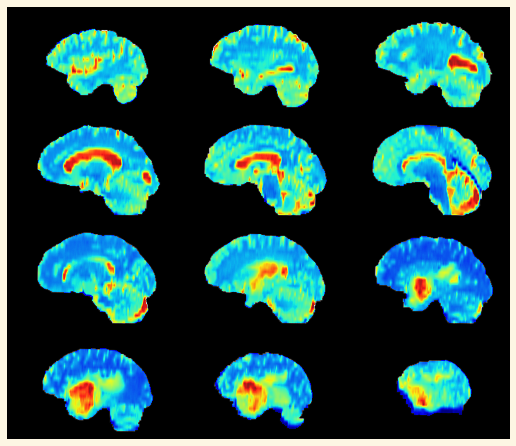

In [47]:
ants.plot(t2_n3bc, overlay=t2)

In [48]:
t2_n3bc_no_zero = t2_n3bc[t2_n3bc!=0]
t2_n3bc_no_zero.shape

(1488860,)

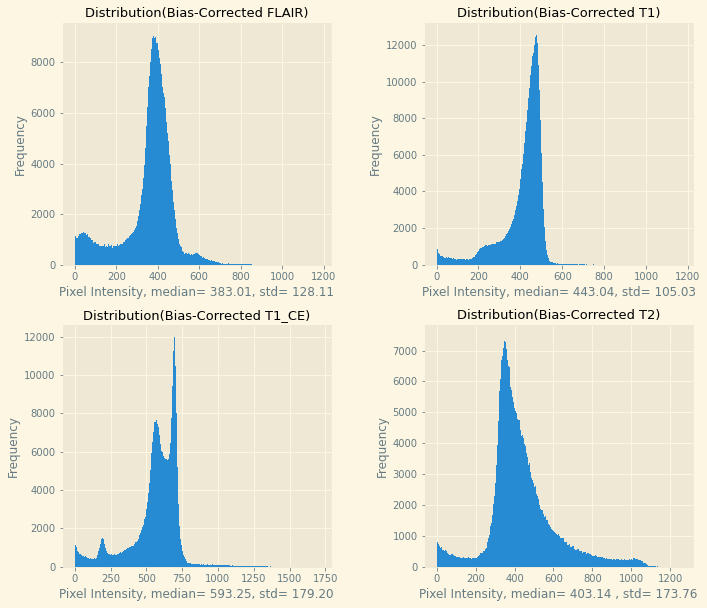

In [55]:
matplotlib.rcParams["figure.figsize"] = [10, 10]
matplotlib.rcParams["figure.subplot.right"] = 1.0
plt.style.use('Solarize_Light2')

plt.subplot(2,2,1)
plt.hist(flair_n3bc_no_zero, bins='sqrt', range=(flair_n3bc_no_zero.min(), flair_n3bc_no_zero.max()))[2]
plt.title("Distribution(Bias-Corrected FLAIR)", fontsize=13)
plt.xlabel("Pixel Intensity, median= %.2f, std= %.2f" % (np.median(flair_n3bc_no_zero), np.std(flair_n3bc_no_zero)) )
plt.ylabel("Frequency")

plt.subplot(2,2,2)
plt.hist(t1_n3bc_no_zero, bins='sqrt', range=(t1_n3bc_no_zero.min(), t1_n3bc_no_zero.max()))[2]
plt.title("Distribution(Bias-Corrected T1)", fontsize=13)
plt.xlabel("Pixel Intensity, median= %.2f, std= %.2f" % (np.median(t1_n3bc_no_zero), np.std(t1_n3bc_no_zero)))
plt.ylabel("Frequency")

plt.subplot(2,2,3)
plt.hist(t1ce_n3bc_no_zero, bins='sqrt', range=(t1ce_n3bc_no_zero.min(), t1ce_n3bc_no_zero.max()))[2]
plt.title("Distribution(Bias-Corrected T1_CE)", fontsize=13)
plt.xlabel("Pixel Intensity, median= %.2f, std= %.2f" % (np.median(t1ce_n3bc_no_zero), np.std(t1ce_n3bc_no_zero)))
plt.ylabel("Frequency")

plt.subplot(2,2,4)
plt.hist(t2_n3bc_no_zero, bins='sqrt', range=(t2_n3bc_no_zero.min(), t2_n3bc_no_zero.max()))[2]
plt.title("Distribution(Bias-Corrected T2)", fontsize=13)
plt.xlabel("Pixel Intensity, median= %.2f , std= %.2f" % (np.median(t2_n3bc_no_zero), np.std(t2_n3bc_no_zero) ))
plt.ylabel("Frequency")


plt.subplots_adjust(wspace=0.35, hspace=0.25)

#### Mask's segmentation labels distrubution

In [235]:
mask.unique()

array([0., 1., 2., 4.], dtype=float32)

In [236]:
mask_no_zero = mask.flatten()[mask.flatten() != 0]
mask_no_zero.shape

(139257,)

In [237]:
mask.flatten().shape[0]

8928000

In [238]:
print("Non-zero label ratio of Mask image tensor: %.4f" % (mask_no_zero.shape[0] / mask.flatten().shape[0]))

Non-zero label ratio of Mask image tensor: 0.0156


Text(0, 0.5, 'Frequency')

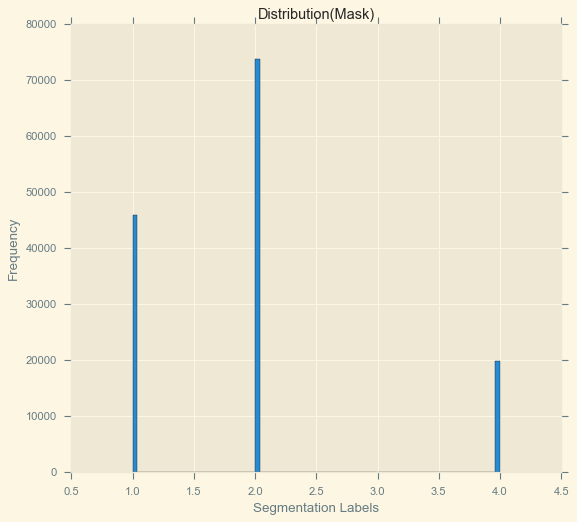

In [239]:
matplotlib.rcParams["figure.figsize"] = [7, 7]

plt.hist(mask_no_zero, bins='auto', range=(mask_no_zero.min(), mask_no_zero.max()))[2]
plt.title("Distribution(Mask)", fontsize=13)
plt.xlabel("Segmentation Labels")
plt.ylabel("Frequency")

## Create a numpy array from ANTsImage objects

In [19]:
img_arr, mask_arr = [imgs[i].numpy() for i in range(len(imgs))], mask.numpy()

*__Note__: we can now treat those as usual numpy array objects.*

In [25]:
[img_arr[i].shape for i in range(len(img_arr))], mask_arr.shape

([(240, 240, 155), (240, 240, 155), (240, 240, 155), (240, 240, 155)],
 (240, 240, 155))

# Reference

[Full decription of orientation](http://www.grahamwideman.com/gw/brain/orientation/orientterms.htm) <br>
[Read docs of ANTsPy](https://antspy.readthedocs.io/en/latest/index.html) <br>
[Read more about the BraTS competition host](https://www.med.upenn.edu/cbica/) <br>
[Check out a free course on brain image preprocessing on Coursera](https://www.coursera.org/learn/neurohacking/home/welcome) <br>